In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nb
import SUITPy as suit
import matplotlib.pyplot as plt
import seaborn as sb
import Functional_Fusion.atlas_map as am
from Functional_Fusion.dataset import *
import Functional_Fusion.matrix as matrix
import sys

base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'

This notebook checks the quality of different dataset using two metrics
a) Within-subject reliability: Pattern Correlation between each partition and the mean of the rest. Here we do mostly split-half correlation 
b) Between-subejct correlation: Pattern correlation between the average pattern for a single subject and the average across all subjects. This will identify outliers  

### Check MDTB dataset

In [3]:
mdtb_dataset = DataSetMDTB(base_dir + '/MDTB')
data_mdtb1,info_mdtb1 = mdtb_dataset.get_data('SUIT3','ses-s1','CondHalf')

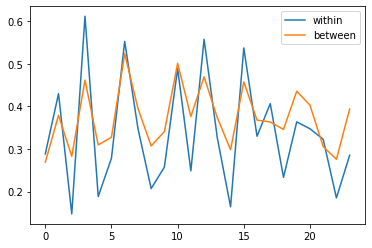

In [4]:
r1 = reliability_within_subj(data_mdtb1,part_vec=info_mdtb1.half,cond_vec=info_mdtb1.cond_name)
r2 = reliability_between_subj(data_mdtb1,cond_vec=info_mdtb1.cond_name)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

In [5]:
data_mdtb2,info_mdtb2 = mdtb_dataset.get_data('SUIT3','ses-s2','CondHalf')

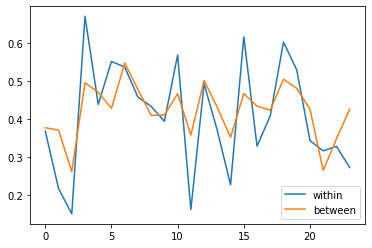

In [6]:
r1 = reliability_within_subj(data_mdtb2,part_vec=info_mdtb2.half,cond_vec=info_mdtb2.cond_name)
r2 = reliability_between_subj(data_mdtb2,cond_vec=info_mdtb2.cond_name)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

### Pontine data set 

In [7]:
mdtb_dataset = DataSetMDTB(base_dir + '/Pontine')
data_pt,info_pt = mdtb_dataset.get_data('SUIT3','ses-01','TaskHalf')

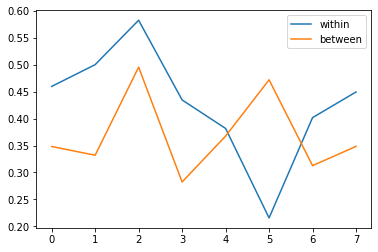

In [8]:
r1 = reliability_within_subj(data_pt,part_vec=info_pt.half,
            cond_vec=info_pt.task_num)
r2 = reliability_between_subj(data_pt,cond_vec=info_pt.task_num)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

### Nishimoto data set

In [10]:
nn_dataset = DataSetNishi(base_dir + '/Nishimoto')
# Specify the fields you want to have / check 
fiel = ['task_name','reg_id','half']
data_nn1,info_nn1 = nn_dataset.get_data('SUIT3','ses-01',
                                        'CondHalf',fields=fiel)
data_nn2,info_nn2 = nn_dataset.get_data('SUIT3','ses-02',
                                        'CondHalf',fields=fiel)


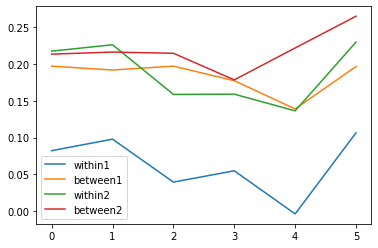

In [11]:
r1w = reliability_within_subj(data_nn1,part_vec=info_nn1.half,cond_vec=info_nn1.reg_id)
r1b = reliability_between_subj(data_nn1,cond_vec=info_nn1.reg_id)
r2w = reliability_within_subj(data_nn2,part_vec=info_nn2.half,cond_vec=info_nn2.reg_id)
r2b = reliability_between_subj(data_nn2,cond_vec=info_nn2.reg_id)
R = np.c_[r1w.mean(axis=1),r1b,r2w.mean(axis=1),r2b]
plt.plot(R)
plt.legend(['within1','between1','within2','between2'])

Interestingly, Data set 1 (training data) has very low within-person reliability. Why is this exactly?

### IBC data set
Do a session-wise test

In [21]:
dataset = DataSetIBC(base_dir + '/IBC')
# Specify the fields you want to have / check 
T = dataset.get_participants()
num_sess = 8
RW = np.empty((T.shape[0],num_sess))
RB = np.empty((T.shape[0],num_sess))
Missing = np.empty((T.shape[0],num_sess))

for i,ses in enumerate(dataset.sessions[:num_sess]):
    data,info = dataset.get_data('MNISymC3',ses,'CondHalf')
    m = np.isnan(data).sum(axis=1)
    Missing[:,i] = (m>0).sum(axis=1)
    rw = reliability_within_subj(data,part_vec=info.half,cond_vec=info.reg_num)
    RW[:,i] = rw.mean(axis=1)
    RB[:,i] = reliability_between_subj(data,cond_vec=info.reg_num)



/Users/jdiedrichsen/Python/Functional_Fusion/dataset.py:151: RuntimeWarning: invalid value encountered in matmul
  X1= pinv(Z[i1,:]) @ X[s,i1,:]
/Users/jdiedrichsen/Python/Functional_Fusion/dataset.py:153: RuntimeWarning: invalid value encountered in matmul
  X2 = pinv(Z[i2,:]) @ X[s,i2,:]
/Users/jdiedrichsen/Python/Functional_Fusion/dataset.py:180: RuntimeWarning: invalid value encountered in matmul
  X1= pinv(Z) @ X[s,:,:]
/Users/jdiedrichsen/Python/Functional_Fusion/dataset.py:182: RuntimeWarning: invalid value encountered in matmul
  X2 = pinv(Z) @ X[i2,:,:].mean(axis=0)
/Users/jdiedrichsen/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:178: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [20]:
Missing

array([[ 46., 137.,  18.,   2.],
       [  0.,   0.,   0.,   0.],
       [  0.,  43.,   0.,   1.],
       [ 38.,   0.,  33.,   0.],
       [  0.,   0.,   0.,   0.],
       [  0.,   0.,  28.,   0.],
       [  1.,   0.,   0.,   0.],
       [  0.,   0.,  11.,   0.],
       [  0.,  23.,   0.,   0.],
       [  0.,   0.,   0.,   0.],
       [  2.,  14.,  29.,  33.],
       [  7.,   0., 151.,  48.]])

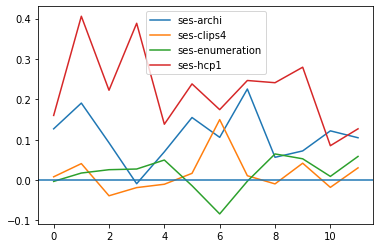

In [18]:
plt.plot(RW)
plt.axhline(0)
plt.legend(dataset.sessions[:num_sess])

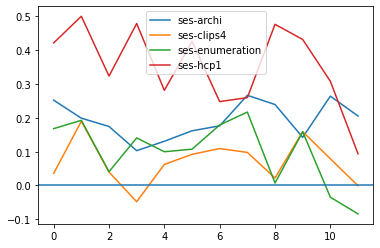

In [19]:
plt.plot(RB)
plt.axhline(0)
plt.legend(dataset.sessions[:num_sess])